/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


             date    price   returns  absreturn  survival
8680   1990-08-25  3164.00 -0.543779   0.543779  0.021277
9480   1987-11-07  2644.67 -0.358663   0.358663  0.042553
9160   1988-12-20  5214.12 -0.273754   0.273754  0.063830
13260  1974-10-28   231.22 -0.244317   0.244317  0.085106
8880   1989-12-11  8176.00 -0.241276   0.241276  0.106383
Taiwan stock index N 777 MS 0.16
             date    price   returns  absreturn  survival
2560   2008-10-21   955.05 -0.218448   0.218448  0.012987
7840   1987-11-12   248.52 -0.181839   0.181839  0.025974
14240  1962-05-28    55.50 -0.161690   0.161690  0.038961
4340   2001-09-26  1007.04 -0.145972   0.145972  0.051948
4080   2002-10-08   798.55 -0.130185   0.130185  0.064935
S&P500 stock index N 867 MS 0.24
Gaussian with same σ as TAIEX mean 0.000347 stdev 0.014374
Gaussian with same σ as TAIEX N 778 MS 0.04


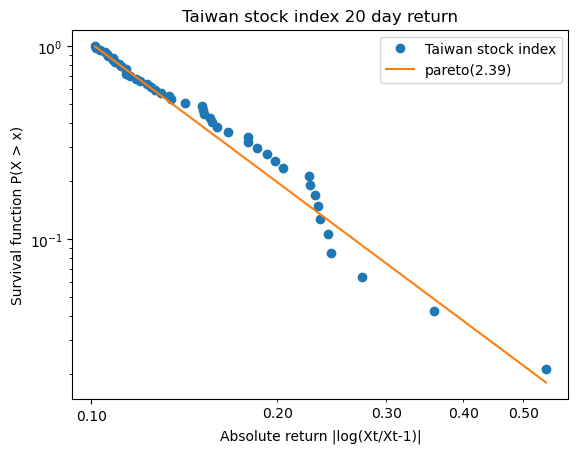

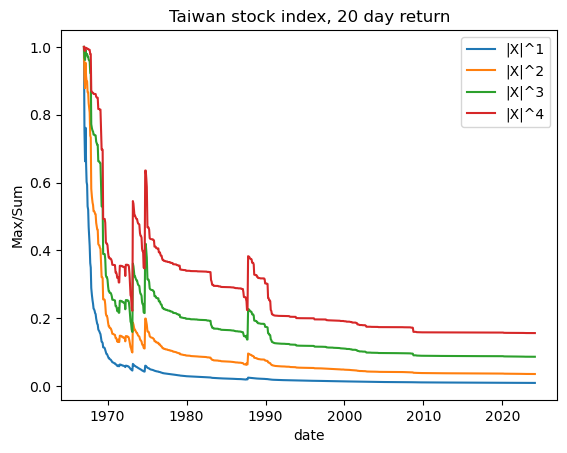

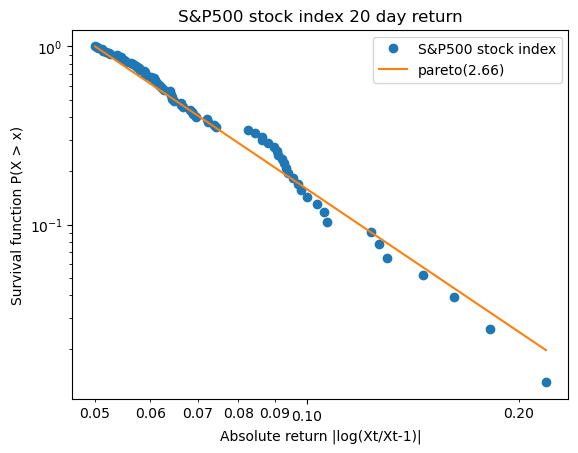

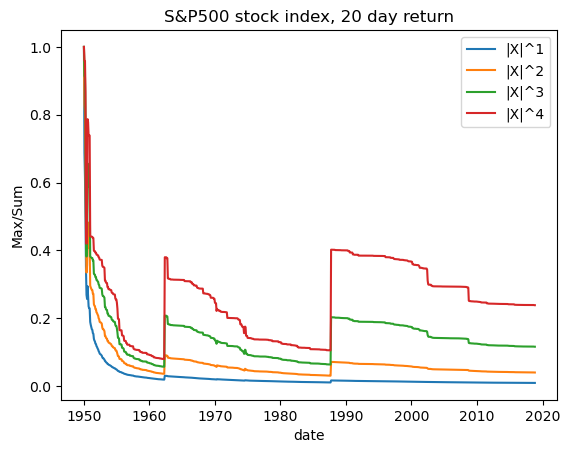

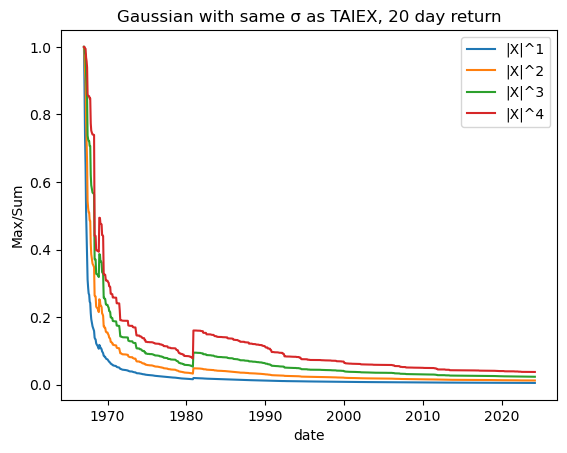

In [1]:
import numpy as np
import pandas
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt


class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def analyzePareto(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    # df["returns"] = df.price / df.price.shift(-analysis.lag)-1
    # df.drop(df.tail(analysis.lag).index,inplace=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = df.price / df.price.shift(-1)-1
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]
    if len(df) == 0:
        return
    
    # Maximum likelihood method. 
    xm = np.min(df.absreturn)
    alpha = len(df)/np.sum(np.log(df.absreturn/xm))

    # Scipy method.
    scipyPareto = scipy.stats.pareto.fit(df.absreturn, scale=analysis.lag*0.02)
    scipyAlpha = scipyPareto[0]

    df = df.sort_values(by='absreturn', ascending=False)
    df["survival"] = 1-(df.absreturn.rank()-1) / len(df)
    fitted = np.power(xm/df.absreturn, alpha)
    
    print(df.head(5))
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.absreturn.to_numpy(), df.survival.to_numpy(), "o", label=analysis.name)
    ax.plot(df.absreturn.to_numpy(), fitted.to_numpy(), label=("pareto(%.2f)"%(alpha)))
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.set_title("%s %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("Absolute return |log(Xt/Xt-1)|")
    ax.set_ylabel("Survival function P(X > x)")
    # fig.savefig("loglog_%s"%analysis.name)


def analyzeMSp(df, p):
    df["Xp%d" % p] = np.power(df.absreturn, p)

    df["msMax%d" % p] = df["Xp%d" % p].cummax()
    if False:
        k = 10
        for i in range(len(df)):
            subset = df.iloc[:i+1]
            vs = subset["Xp%d" % p].to_numpy().copy()
    
            vs = np.sort(vs)
            largest = vs[max(0, len(vs)-k):]
            mx = np.sum(largest)
    
            df.iloc[i, df.columns.get_loc("msMax%d" % p)] = mx
            
    
    df["msSum%d" % p] = df["Xp%d" % p].cumsum()
    df["ms%d" % p] = df["msMax%d" % p] / df["msSum%d" % p]


def plotMS(analysis, df):
    fig, ax = plt.subplots(1, 1)
    for p in [1, 2, 3, 4]:
        analyzeMSp(df, p)
        x = matplotlib.dates.date2num(df.date)
        y = df["ms%d" % p].to_numpy()
        x = x[0:]
        y = y[0:]
        ax.plot_date(x, y, fmt="-", label=("|X|^%d" % p))
    ax.legend()
    ax.set_title("%s, %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("date")
    ax.set_ylabel("Max/Sum")
    # fig.savefig("ms_%s"%analysis.name)
    print("%s N %d MS %.2f" % (analysis.name, len(df), df.iloc[len(df)-1]["ms4"]))


def analyzeMS(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))

    plotMS(analysis, df)
    #df.to_csv("qqq.csv")


def analyze(analysis):
    analyzePareto(analysis)
    analyzeMS(analysis)


# Plot a MS-plot for a normal distribution corresponding to TAIEX.
def ms_taiex_gaussian():
    analysis = Analysis()
    analysis.name = "Gaussian with same σ as TAIEX"
    analysis.lag = 20
    
    # Compute daily standard deviation
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    mean = np.mean(df.returns)
    std = np.std(df.returns)
    print("%s mean %f stdev %f" % (analysis.name, mean, std))
    
    # Simulate a normal distribution using the computed standard deviation.
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    mean *= analysis.lag
    std *= np.sqrt(analysis.lag)
    df["absreturn"] = np.abs(np.random.normal(loc=mean, scale=std, size=len(df)))
    plotMS(analysis, df)


for lag in [20]:
    for tailCutoff in [0.005]:
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analyze(analysis)
        
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.tailCutoff = 0.0025
        analyze(analysis)
ms_taiex_gaussian()

In [2]:
def paretoWithVariance(alpha):
    scale = np.sqrt((alpha-1)*(alpha-1)*(alpha-2)/alpha)
    distribution = scipy.stats.pareto(alpha, scale=scale)
    return distribution


class PDF:
    def __init__(self, x, pdf):
        self.x = x
        self.pdf = pdf


def getPDF(data, bins):
    hist = np.histogram(data, bins=bins)
    x = (hist[1][:-1] + hist[1][1:])/2
    pdf = hist[0]/len(data)
    return PDF(x, pdf)


def varianceDistribution(analysis):
    runs = 10000
    size = int(analysis.mcSize / runs)
    variance = np.zeros((runs, size))
    for i in range(runs):
        data = np.reshape(analysis.distribution.rvs(analysis.sampleSize*size), (size, analysis.sampleSize))
        variance[i] = np.var(data, axis=1)
        if (i % (runs/100)) == 0:
            print("%s run %d" % (analysis.name, i))
    variance = np.reshape(variance, analysis.mcSize)
    
    pdfAll = getPDF(variance, analysis.bins)

    # Zoom into our expected area for the chi-square distribution.
    subset = variance[variance<3]
    pdf02 = getPDF(subset, analysis.bins)
    pdf02.pdf *= len(subset) / len(variance)

    print(analysis.upperSignificance)
    upper = np.percentile(variance, analysis.upperSignificance)
    
    return ((pdfAll, pdf02), upper)


def analyze(analysis):
    print("%s variance: %f"%(analysis.name, analysis.distribution.var()))
    
    pdfs, upper = varianceDistribution(analysis)

    for pdf in pdfs:
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 0, "%d%% percentile %.4f"%(analysis.upperSignificance, upper), horizontalalignment="center")
        ax.set_title("%s, variance distribution of sample size %d" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")
        
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 1e-3, "%d%% percentile %.4f"%(analysis.upperSignificance, upper))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title("%s, variance distribution of sample size %d, log-log plot" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")


class Analysis:
    def __init__(self, name, sampleSize, bins, mcSize, distribution):
        self.name = name
        self.sampleSize = sampleSize
        self.bins = bins
        self.mcSize = int(bins*mcSize)
        self.distribution = distribution
        self.upperSignificance = 95


bins = 100
# analyze(Analysis("gaussian", 777, bins, 1e4, scipy.stats.norm()))
alpha = 2.39
# analyze(Analysis("pareto %.2f"%alpha, 777, bins, 1e4, paretoWithVariance(alpha)))
# analyze(Analysis("pareto %.2f"%alpha, 1000000, bins, 1e3, paretoWithVariance(alpha)))

98 0.29958850124715913 1.8511535903581637 6.178987453296716
124 0.3517441727491572 2.512694316436089 7.143527913475888


Text(0, 0.5, 'skewness')

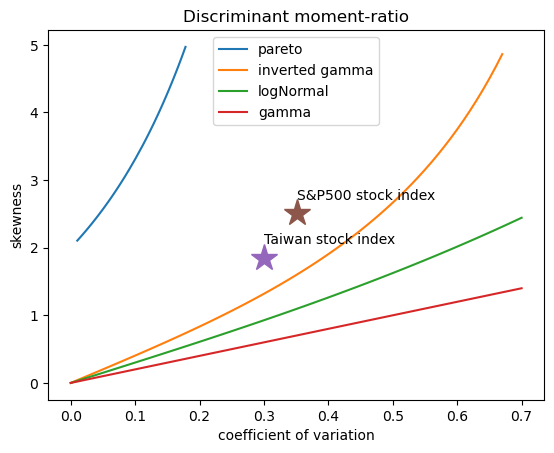

In [3]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001

        self.n = 0
        self.cv = 0
        self.skew = 0
        

def paretoCurve(maxX, maxY):
    p = np.concatenate([
        np.arange(3.01, 5, 0.01),
        np.arange(5.1, 10, 0.1),
        np.arange(10, 100, 1),
        ])
    x = 1/np.sqrt(p*(p-2))
    y = (1+p)/(p-3)*2/np.sqrt(1-2/p)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def invertedGammaCurve(maxX, maxY):
    gMaxX = min(1, maxX)
    n = 100
    
    x = np.arange(0, gMaxX-1/n, 1/n)
    y = 4*x/(1-x*x)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def logNormalCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    w = x*x + 1
    y = (w+2)*np.sqrt(w-1)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def gammaCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    y = 2*x

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def plotMomentRatio(ax, cv, skew):
    maxX = 2 * cv
    maxY = 2 * skew
    x = np.arange(0, maxX, maxX/100)
    
    pareto = paretoCurve(maxX, maxY)
    invertedGamma = invertedGammaCurve(maxX, maxY)
    logNormal = logNormalCurve(maxX, maxY)
    gamma = gammaCurve(maxX, maxY)

    ax.plot(pareto[:, 0], pareto[:, 1], label="pareto")
    ax.plot(invertedGamma[:, 0], invertedGamma[:, 1], label="inverted gamma")
    ax.plot(logNormal[:, 0], logNormal[:, 1], label="logNormal")
    ax.plot(gamma[:, 0], gamma[:, 1], label="gamma")


def analyzeMomentRatio(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    analysis.n = len(df)
    analysis.cv = np.std(df.absreturn) / np.mean(df.absreturn)
    analysis.skew = scipy.stats.skew(df.absreturn)

    print(analysis.n, analysis.cv, analysis.skew, analysis.skew/analysis.cv)


ans = []

analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 10
analysis.tailCutoff = 0.01
analyzeMomentRatio(analysis)
ans.append(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 10
analysis.tailCutoff = 0.005
analyzeMomentRatio(analysis)
ans.append(analysis)

fig, ax = plt.subplots(1, 1)
plotMomentRatio(ax, np.max([a.cv for a in ans]), np.max([a.skew for a in ans]))
for analysis in ans:
    ax.plot(analysis.cv, analysis.skew, "*", markersize=20)
    ax.text(analysis.cv, analysis.skew+0.2, analysis.name)
ax.legend(loc="upper center")
ax.set_title("Discriminant moment-ratio")
ax.set_xlabel("coefficient of variation")
ax.set_ylabel("skewness")

88 88
114 114


/tmp/ipykernel_191891/2914324495.py:17: RuntimeWarning: invalid value encountered in scalar divide
  eu = np.sum(larger-u) / len(larger)
/tmp/ipykernel_191891/2914324495.py:17: RuntimeWarning: invalid value encountered in scalar divide
  eu = np.sum(larger-u) / len(larger)


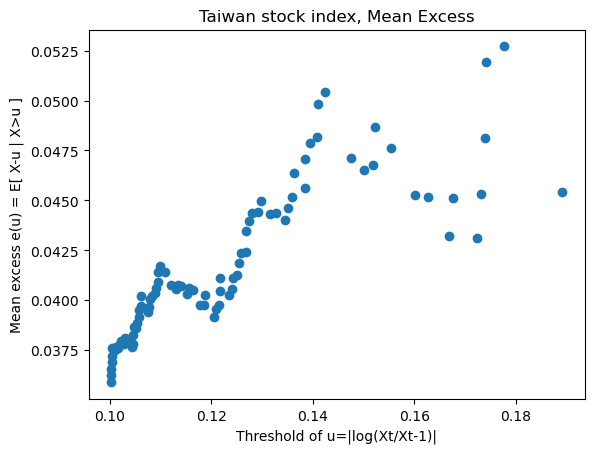

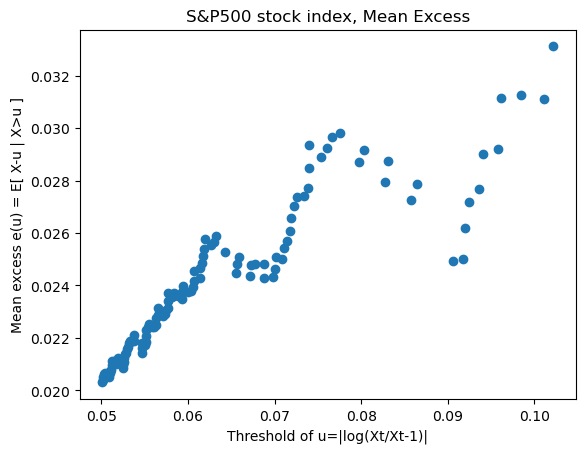

In [4]:
def analyzeME(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    #df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    orderedStats = np.sort(df.absreturn)
    excess = []
    for i in range(len(orderedStats)):
        u = orderedStats[i]
        larger = orderedStats[i+1:]
        eu = np.sum(larger-u) / len(larger)
        excess.append(eu)

    lastRemoveN = 10
    u = orderedStats[:-lastRemoveN]
    eu = np.array(excess)[:-lastRemoveN]
    print(len(u), len(eu))

    fig, ax = plt.subplots(1, 1)
    ax.plot(u, eu, "o")
    ax.set_title("%s, Mean Excess"%(analysis.name))
    ax.set_xlabel("Threshold of u=|log(Xt/Xt-1)|")
    ax.set_ylabel("Mean excess e(u) = E[ X-u | X>u ]")


analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 10
analysis.tailCutoff = 0.01
analyzeME(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 10
analysis.tailCutoff = 0.005
analyzeME(analysis)